# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/roundscad_UN_roundscad_UN.csv.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/roundscad_DA_roundscad_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,841,Fish (roundscad) - Retail,5,KG,5,2020,178.15
1,841,Fish (roundscad) - Retail,5,KG,5,2020,183.50
2,841,Fish (roundscad) - Retail,5,KG,5,2020,200.00
3,841,Fish (roundscad) - Retail,5,KG,5,2020,192.78
4,841,Fish (roundscad) - Retail,5,KG,5,2020,135.00
...,...,...,...,...,...,...,...
1132,841,Fish (roundscad) - Retail,5,KG,6,2021,166.25
1133,841,Fish (roundscad) - Retail,5,KG,6,2021,140.00
1134,841,Fish (roundscad) - Retail,5,KG,6,2021,229.38
1135,841,Fish (roundscad) - Retail,5,KG,6,2021,141.25


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,"Fish (roundscad, local) - Retail",NaN,KG,1,2022,228.42
1,NaN,"Fish (roundscad, local) - Retail",NaN,KG,2,2022,231.75
2,NaN,"Fish (roundscad, local) - Retail",NaN,KG,3,2022,228.43
3,NaN,"Fish (roundscad, local) - Retail",NaN,KG,4,2022,229.42
4,NaN,"Fish (roundscad, local) - Retail",NaN,KG,5,2022,226.38


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,178.15,2020-05-15
1,183.50,2020-05-15
2,200.00,2020-05-15
3,192.78,2020-05-15
4,135.00,2020-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,228.42,2022-01-15
1,231.75,2022-02-15
2,228.43,2022-03-15
3,229.42,2022-04-15
4,226.38,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

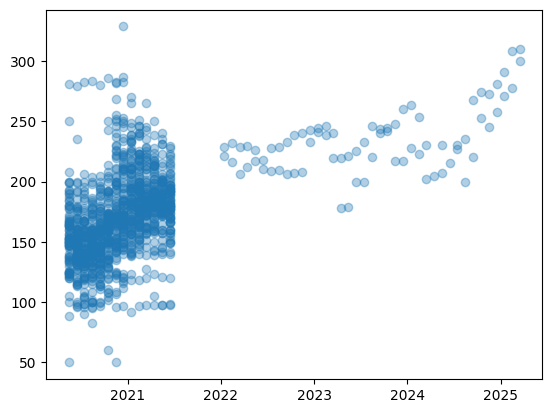

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2020-05-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [23]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

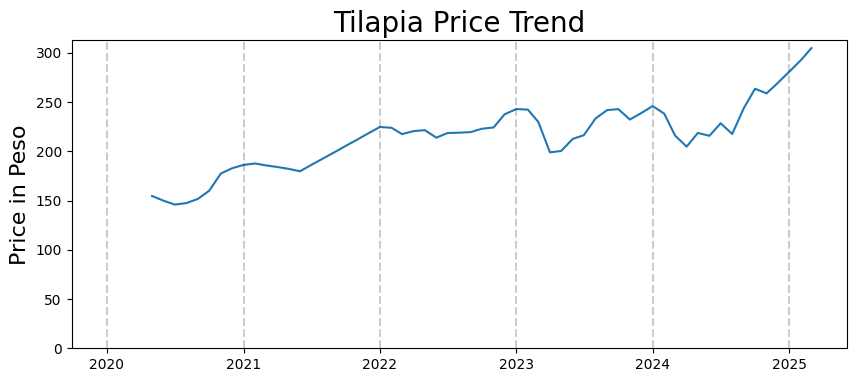

In [24]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [25]:
first_diff = lim_tilapia.diff()[1:]

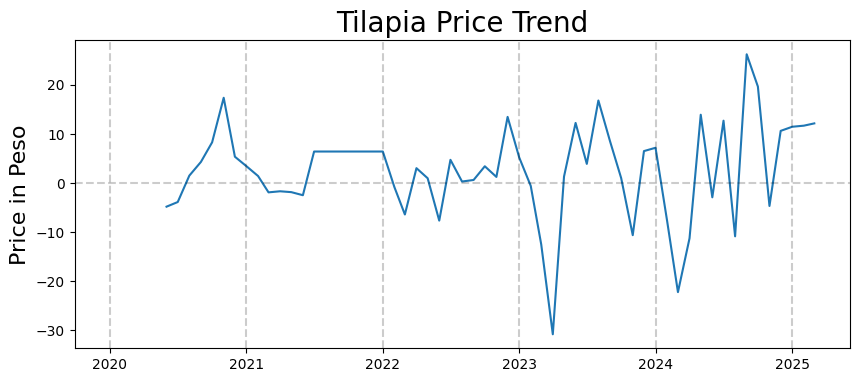

In [26]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [27]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

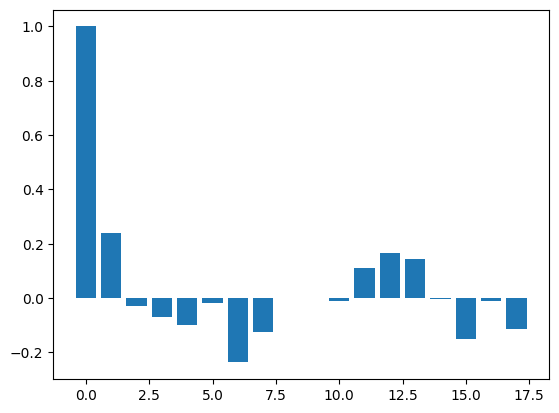

In [31]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

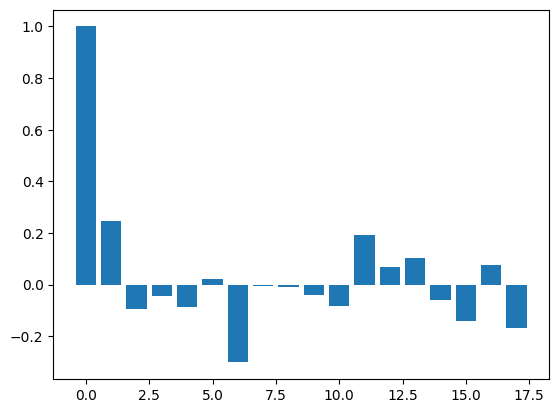

In [33]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [34]:
from datetime import timedelta

In [35]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [36]:
Tilapia.describe()

,mp_price
count,59.000000
mean,215.016326
std,34.325901
min,145.946977
25%,190.143393
50%,218.319537
75%,235.505000
max,304.845000


## Fit the SARIMA Model

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [39]:
from time import time

In [40]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64048D+00    |proj g|=  1.32884D-01

At iterate    5    f=  3.56165D+00    |proj g|=  2.20772D-03

At iterate   10    f=  3.56157D+00    |proj g|=  1.29384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   4.729D-07   3.562D+00
  F =   3.5615739676082625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fitting Time: 0.1906726360321045


 This problem is unconstrained.


In [41]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -188.763
Date:                              Tue, 20 May 2025   AIC                            383.527
Time:                                      17:18:01   BIC                            389.381
Sample:                                  05-01-2020   HQIC                           385.771
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6619      0.685      0.966      0.334      -0.681       2.004
ma.S.L12      -0.34

In [42]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01   263.550
2024-11-01   258.880
2024-12-01   269.515
2025-01-01   280.990
2025-02-01   292.685


In [43]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [44]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [45]:
predictions

date
2024-10-01    244.951614
2024-11-01    242.251837
2024-12-01    246.109123
2025-01-01    249.245992
2025-02-01    246.739005
2025-03-01    238.091426
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
residuals

date
2024-10-01    18.598386
2024-11-01    16.628163
2024-12-01    23.405877
2025-01-01    31.744008
2025-02-01    45.945995
2025-03-01    66.753574
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

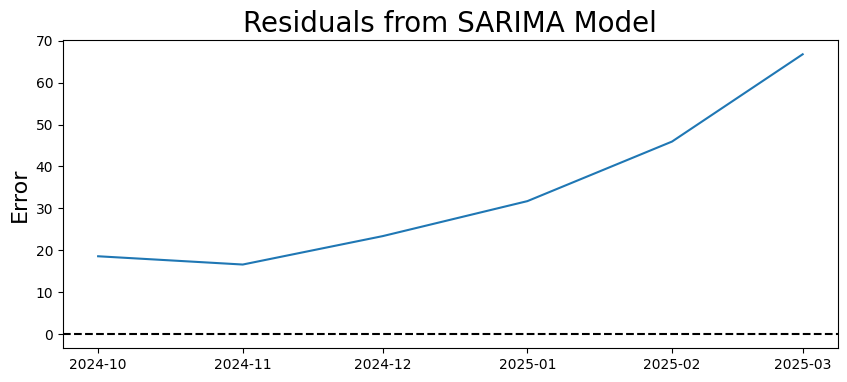

In [47]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

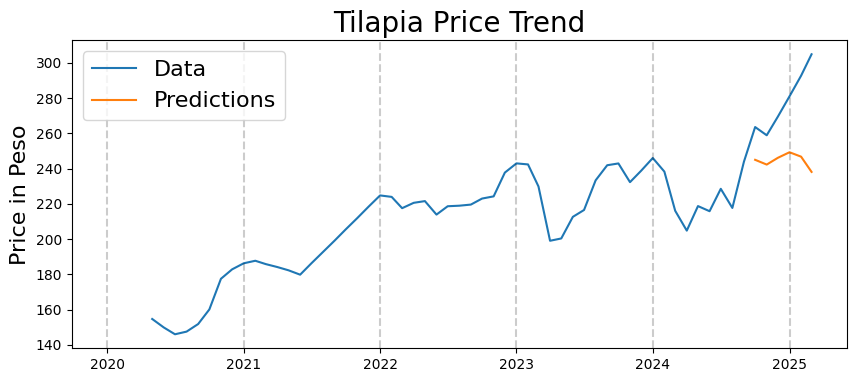

In [48]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [49]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64048D+00    |proj g|=  1.32884D-01

At iterate    5    f=  3.56165D+00    |proj g|=  2.20772D-03

At iterate   10    f=  3.56157D+00    |proj g|=  1.29384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   4.729D-07   3.562D+00
  F =   3.5615739676082625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  3.61335D+00    |proj g|=  1.17824D-01

At iterate   10    f=  3.58439D+00    |proj g|=  5.59900D-03

At iterate   15    f=  3.58416D+00    |proj g|=  6.32055D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   9.019D-06   3.584D+00
  F =   3.5841536529130464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67710D+00    |proj g|=  1.95170D-01

At iter

/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   10    f=  3.57916D+00    |proj g|=  1.91396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   8.659D-06   3.579D+00
  F =   3.5790070054277208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66508D+00    |proj g|=  1.43396D-01

At iterate    5    f=  3.62191D+00    |proj g|=  1.08177D-01

At iterate   10    f=  3.59259D+00    |proj g|=  7.03637D-03

At iter

/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_20819/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [50]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

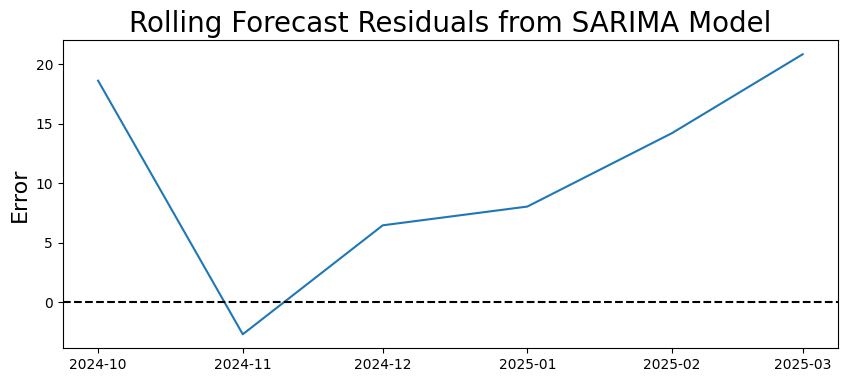

In [51]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

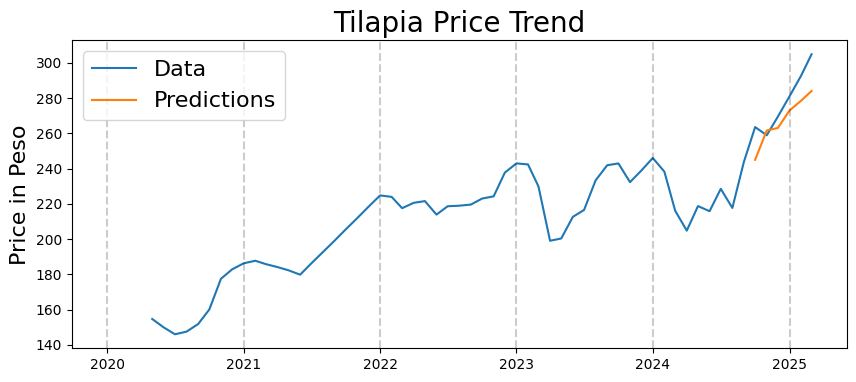

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
import numpy as np

In [54]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0417


In [55]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 13.504895751984446


## Future Predictions (2025)